You can run this notebook directly on Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DaniAffCH/Vessel-Geometric-Transformers/blob/main/main.ipynb)

In [ ]:
import sys

COLAB_RUNTIME = 'google.colab' in sys.modules
if COLAB_RUNTIME:
    !git clone https://github.com/DaniAffCH/Vessel-Geometric-Transformers.git
    !mv Vessel-Geometric-Transformers/* . 
    !pip install -q -r requirements.txt
else: # Development mode, setting precommit checks 
    !pip install -r requirements.txt
    !pre-commit autoupdate
    !pre-commit install


  Using cached lightning-2.4.0-py3-none-any.whl.metadata (38 kB)
^C
ERROR: Operation cancelled by user


Loading the configuration

In [1]:
from src.utils import load_config
import os
from config import DatasetConfig, TrainerConfig, BaselineConfig, GatrConfig

config_path = os.path.join("config","config.yaml")

config = load_config(config_path)
dataset_config: DatasetConfig = config.dataset
trainer_config: TrainerConfig = config.trainer
baseline_config: BaselineConfig = config.baseline
gatr_config: GatrConfig = config.gatr

---

Loading the dataset

In [2]:
from src.data import VesselDataModule
from src.utils.data_analysis import data_info

data = VesselDataModule(dataset_config)
data_info(data)

/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe

Train size: 2999
Val size: 599
Test size: 401
One Sample: Data(pos=[8397, 3], wss=[8397, 3], pressure=[8397], face=[3, 16790], inlet_index=[214], label=Category.Single)


100%|██████████| 3999/3999 [00:00<00:00, 9291.65it/s]


,Mean,Median,Std,Min,Max
WSS,13011.76019,11387.0,4271.667184,5466,24800
POS,13011.76019,11387.0,4271.667184,5466,24800
FACE,26019.52038,22770.0,8543.334368,10928,49596
PRESSURE,13011.76019,11387.0,4271.667184,5466,24800


Data distribution

<Axes: xlabel='count'>

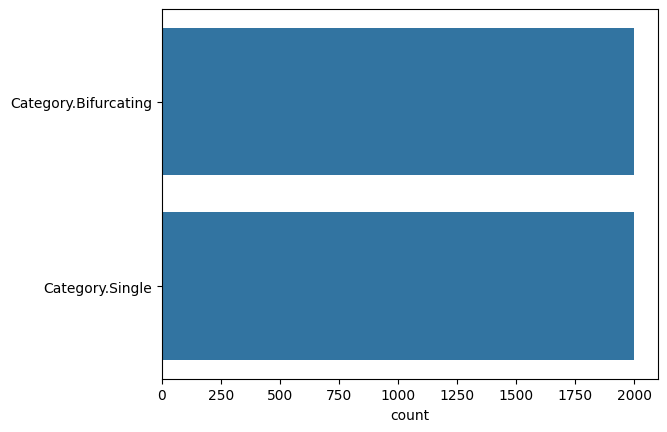

In [3]:
import seaborn as sns
sns.countplot(data.data.label)

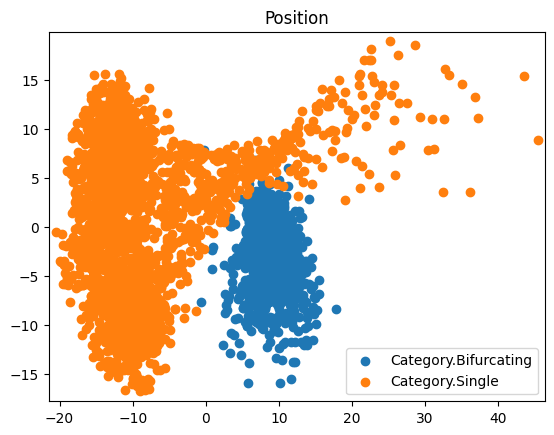

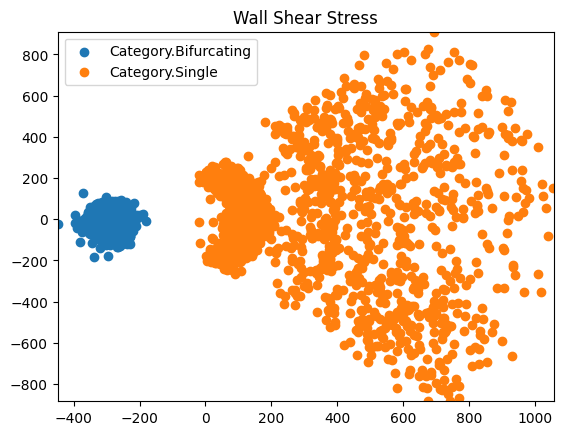

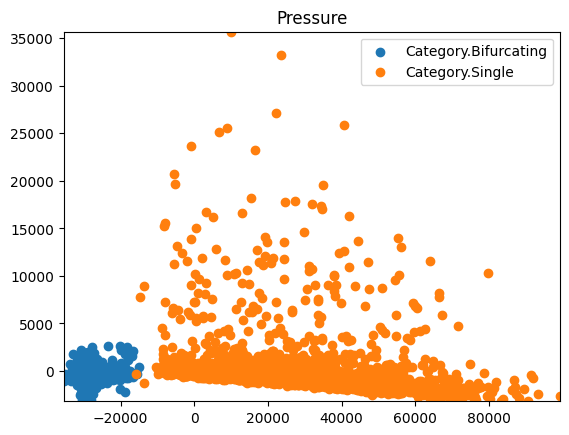

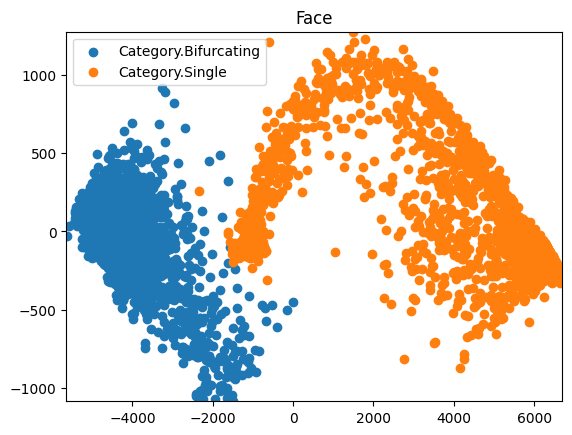

In [4]:
from src.utils.definitions import Feature, Category
from src.utils.data_analysis import plot_data

wss, labels = data.extract_feature(Feature.WSS)
pos, labels = data.extract_feature(Feature.POS)
pressure, labels = data.extract_feature(Feature.PRESSURE)
face, labels = data.extract_feature(Feature.FACE)
plot_data(pos, labels, Category, "Position")
plot_data(wss, labels, Category, "Wall Shear Stress")
plot_data(pressure, labels, Category, "Pressure")
plot_data(face, labels, Category, "Face")

---

Performing equivariance check

In [5]:
from src.lib.geometricAlgebraElements import GeometricAlgebraBase
from src.test.test_equivariance import TestEquivariance
import unittest

dl = data.train_dataloader()

batch = next(iter(dl)).data[0]
batch = batch.view(-1, GeometricAlgebraBase.GA_size)[:10]
TestEquivariance.INPUT_DATA = batch

suite = unittest.TestSuite()
suite.addTests(unittest.TestLoader().loadTestsFromTestCase(TestEquivariance))
test_runner = unittest.TextTestRunner(verbosity=0)
restResult = test_runner.run(suite)

/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)



✅ GeometricBilinearLayer passed all equivariance tests with a tolerance of 1e-05.                  [10 inputs, 100 checks each]

✅ EquiLinearLayer passed all equivariance tests with a tolerance of 1e-05.                  [10 inputs, 100 checks each]

✅ EquiNormLayer passed all equivariance tests with a tolerance of 1e-05.                  [10 inputs, 100 checks each]


FAIL: test_geomattention_layer (src.test.test_equivariance.TestEquivariance)
Tests the equivariance of the GeometricAttentionLayer.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/src/test/test_equivariance.py", line 124, in test_geomattention_layer
    self.assertTrue(
AssertionError: False is not true : GeometricAttentionLayer failed the equivariance                     test for input 1

----------------------------------------------------------------------
Ran 5 tests in 7.214s

FAILED (failures=1)



✅ GatedGELU passed all equivariance tests with a tolerance of 1e-05.                  [10 inputs, 100 checks each]


---

Baseline (trainin and testin)

In [ ]:
from src.trainer import VesselTrainer
from src.models import BaselineTransformer
from src.utils.hpo import baseline_hpo

baseline_hpo(config)
trainer = VesselTrainer(trainer_config)
model = BaselineTransformer(baseline_config)
trainer.fit(model, data)

/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-10 09:26:43,566] A new study created in memory with name: baseline_hpo
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future rele

Starting a new hyperparameter optimization study...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | encoder        | TransformerEncoder | 6.7 K  | train
1 | embedder       | Linear             | 272    | train
2 | projection     | Linear             | 19.2 K | train
3 | loss_fn        | BCEWithLogitsLoss  | 0      | train
4 | train_accuracy | BinaryAccuracy     | 0      | train
5 | val_accuracy   | BinaryAccuracy     | 0      | train
6 | test_accuracy  | BinaryAccuracy     | 0      | train
7 | train_f1       | BinaryF1Score      | 0      | train
8 | val_f1         | BinaryF1Score      | 0      | train
9 | test_f1        | BinaryF1Score      | 0      | train
--------------------------------------------------------------
26.2 K    Trainable params
0         Non-trainable params
26.2 K    Total params
0.105     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 750/750 [00:47<00:00, 15.92it/s, v_num=72, val/loss=0.0415, val/acc=0.988, val/f1=0.988, train/loss=0.0869, train/acc=0.975, train/f1=0.975]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 750/750 [00:47<00:00, 15.91it/s, v_num=72, val/loss=0.0415, val/acc=0.988, val/f1=0.988, train/loss=0.0869, train/acc=0.975, train/f1=0.975]


[I 2024-10-10 09:29:08,397] Trial 0 finished with value: 0.041525036096572876 and parameters: {'lr': 0.00031489116479568613, 'num_heads': 4, 'num_layers': 3, 'batch_size': 4}. Best is trial 0 with value: 0.041525036096572876.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Trial 0 finished with value 0.041525036096572876


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | encoder        | TransformerEncoder | 2.2 K  | train
1 | embedder       | Linear             | 272    | train
2 | projection     | Linear             | 19.2 K | train
3 | loss_fn        | BCEWithLogitsLoss  | 0      | train
4 | train_accuracy | BinaryAccuracy     | 0      | train
5 | val_accuracy   | BinaryAccuracy     | 0      | train
6 | test_accuracy  | BinaryAccuracy     | 0      | train
7 | train_f1       | BinaryF1Score      | 0      | train
8 | val_f1         | BinaryF1Score      | 0      | train
9 | test_f1        | BinaryF1Score      | 0      | train
--------------------------------------------------------------
21.7 K    Trainable params
0         Non-trainable params
21.7 K    Total params
0.087     Total estimated model params size (MB)


In [ ]:
trainer.test(model, data)

---

Gatr

In [ ]:
from src.trainer import VesselTrainer
from src.models import Gatr
from src.utils.hpo import gatr_hpo

gatr_hpo(config)
trainer = VesselTrainer(trainer_config)
model = Gatr(gatr_config)
trainer.fit(model, data)

In [9]:
trainer.test(model, data)

----